<a href="https://colab.research.google.com/github/keklmaokeklmao/OCR_new/blob/main/Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print('hello world')

hello world


In [ ]:
# we do not use cnn for image extraction , trocr uses transformer for image extraction
# noise can be edges,creases and ink blots
# first do image segmentation and then apply trocr for final approach

In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
!nvidia-smi

Sun Jan 14 12:35:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Dataset

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words

!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
# data/words have a01->a01-000u followed by individual images(line no.,word no.)

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup # maps string features to indices values
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

##Splitting of Data

In [ ]:
base_path = "/content/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] =="#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)
np.random.shuffle(words_list)

In [ ]:
len(words_list)

96456

In [ ]:
words_list[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']

In [ ]:
train_ratio = int(0.9*len(words_list))
train_samples = words_list[:train_ratio]
test_samples = words_list[train_ratio:]

val_ratio = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_ratio]
test_samples = test_samples[val_ratio:]

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total Validation samples: {len(validation_samples)}")
print(f"Total Test samples: {len(test_samples)}")

Total Training Samples: 86810
Total Validation samples: 4823
Total Test samples: 4823


##Input Data

In [ ]:
base_image_path = os.path.join(base_path, "words") # now points to /content/data/words
print(base_path)
def get_image_paths_and_labels(samples): # sample is from words.txt file
    paths = []
    corrected_labels = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip() # remove whitespace
        line_split = line_split.split(" ")

        # Each line split will have this format for the the corresponding image:part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
             base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_labels.append(file_line.split("\n")[0])

    return paths, corrected_labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

/content/data


In [ ]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [ ]:
train_img_paths[0:10]

['/content/data/words/e04/e04-030/e04-030-04-08.png',
 '/content/data/words/k02/k02-102/k02-102-05-03.png',
 '/content/data/words/a01/a01-082u/a01-082u-01-04.png',
 '/content/data/words/m01/m01-000/m01-000-07-00.png',
 '/content/data/words/g01/g01-031/g01-031-07-06.png',
 '/content/data/words/f07/f07-081b/f07-081b-01-06.png',
 '/content/data/words/n03/n03-082/n03-082-04-03.png',
 '/content/data/words/g06/g06-018c/g06-018c-04-05.png',
 '/content/data/words/g06/g06-011j/g06-011j-06-06.png',
 '/content/data/words/f04/f04-024/f04-024-01-06.png']

In [ ]:
train_labels_cleaned = []
characters = set() # for unique characters
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

Maximum length:  21
Vocab size:  78


In [ ]:
train_labels_cleaned[:10]

['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [ ]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
ff=list(characters) # everytime new sorting

In [ ]:
ff

['y',
 'o',
 '#',
 '*',
 'E',
 'a',
 '+',
 'J',
 'c',
 'm',
 ':',
 'G',
 '.',
 '8',
 '!',
 'B',
 '0',
 '4',
 'F',
 '9',
 'd',
 ';',
 'Z',
 '5',
 'k',
 'U',
 'h',
 't',
 "'",
 '(',
 '/',
 'X',
 'V',
 'b',
 'K',
 'M',
 'Q',
 'j',
 '"',
 '&',
 'H',
 'P',
 'g',
 'D',
 'l',
 'A',
 'i',
 '1',
 ')',
 'f',
 'Y',
 'N',
 '-',
 'L',
 'w',
 'e',
 'C',
 'T',
 'p',
 'R',
 ',',
 'I',
 '3',
 '6',
 'x',
 'O',
 '7',
 '?',
 'v',
 'r',
 's',
 'u',
 'W',
 'z',
 'S',
 'q',
 'n',
 '2']

In [ ]:
vocab=['k', "'", 'U', '6', 'f', 'l', 'G', 'D', 'b', 'y', 'R', 'Y', 'X', '8', 'Q', 'M', 'e', 'P', 'r', 'i', 'N', 'K', 'v', 'E', 'W', ',', 'T', 'm', '2', 'p', ';', 'j', ')', 'I', '-', '(', 'F', 't', '&', '#', 'a', 'n', 'x', '"', 'B', 'g', '5', 'u', '!', 'J', 'H', 's', 'Z', 'o', 'd', '7', 'S', 'V', 'C', 'c', 'A', '0', '3', '9', 'z', ':', 'O', '.', '?', '/', 'w', '*', '+', '1', 'h', 'L', '4', 'q']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # automatic optimization study once again

char_to_num = StringLookup(vocabulary=vocab, mask_token=None)
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True) # for no distortion of image

  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

# for symmetrical padding
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0],],)
  image = tf.transpose(image, perm=[1,0,2]) # permutation
  image = tf.image.flip_left_right(image) # flips the image horizontally
  return image

In [ ]:
batch_size = 64
padding_token = 100
image_width = 128
image_height = 32

In [ ]:
def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0 # normalization
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token) # padding the label to uniform length i.e. max_length
  return label

def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

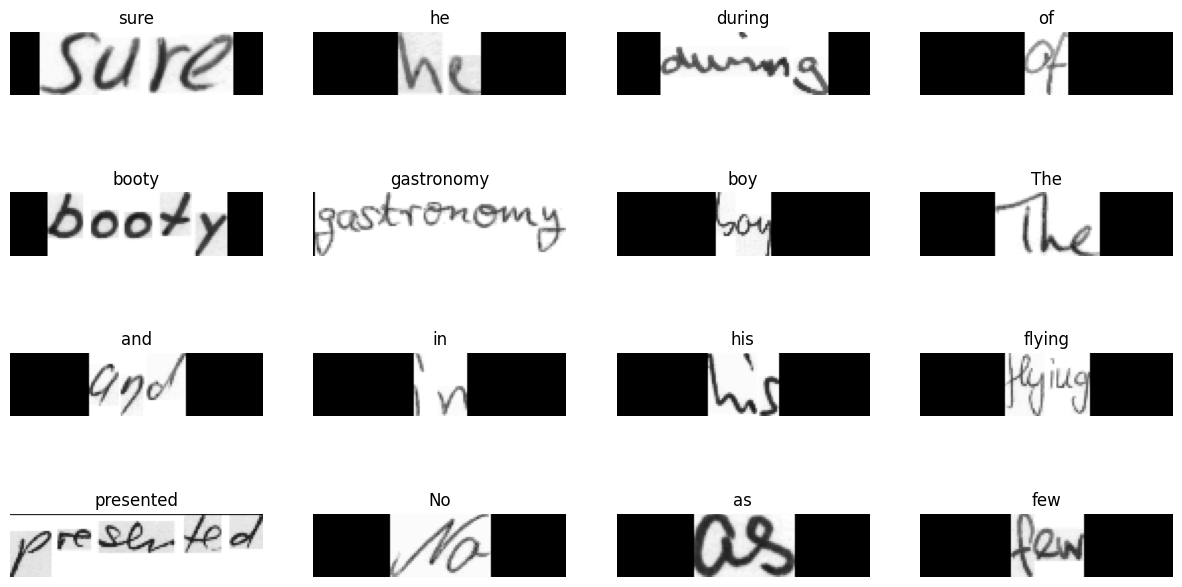

In [ ]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0] # grey colour

    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    label = tf.strings.reduce_join(num_to_chars(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()

##Model

In [ ]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)
    return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image") # grey-scale image
  labels = keras.layers.Input(name="label", shape=(None,))

  # first Conv layer
  x = keras.layers.Conv2D(32, (3,3), activation = "relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  # Second Conv layer
  x = keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal",padding="same",name="Conv2")(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x) # image is image/4


  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN
  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
  # +2 is to account for the two special tokens introduced by the CTC loss.
  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="Digitizing_text")
  opt = keras.optimizers.Adam()
  model.compile(optimizer=opt)
  return model

model = build_model()
model.summary()

Model: "Digitizing_text"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                                    

##Evaluation

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

In [ ]:
# Edit distance as evaluation metric
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
  sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean eidt distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

##Training

In [ ]:
epochs = 63
model = build_model()
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_v8.h5")
prediction_model.save("/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_50_epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 9ms/step


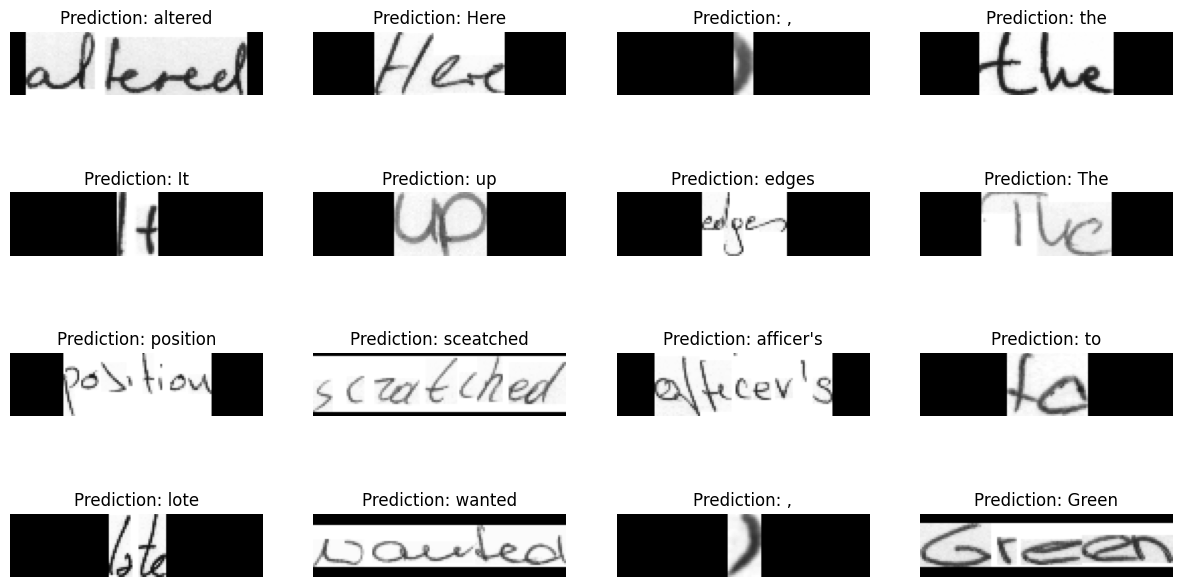

In [ ]:
# A utility function -> used for testing
pred_test_text = []
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [ ]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['altered', 'Here', ',', 'the', 'It', 'up', 'edges', 'The', 'position', 'sceatched', "afficer's", 'to', 'lote', 'wanted', ',', 'Green', 'inspiration', '.', 'He', 'irritatea', 'he', 'weaks', 'to', 'feing', ',', 'and', 'of', 'opened', 'Phetan', 'of', 'is', 'rigteousners', 'saw', 'talles', 'har', 'weekdays', 'My', 'a', 'thee', 'illn-', 'some', 'pot', 'Dounis', 'dealt', 'new', 'to', 'at', 'is', 'men', 'not', 'live', 'and', 'united', 'heaths', 'of', 'AT', 'lead', 'much', ',', 'do', 'of', 'the', 'when', 'allough']


In [ ]:
sentence = ' '.join(flat_list)
print(sentence)

altered Here , the It up edges The position sceatched afficer's to lote wanted , Green inspiration . He irritatea he weaks to feing , and of opened Phetan of is rigteousners saw talles har weekdays My a thee illn- some pot Dounis dealt new to at is men not live and united heaths of AT lead much , do of the when allough


##Inference on New set of images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow
import tensorflow as tf
from tensorflow import keras

In [ ]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)
    return y_pred

NameError: name 'keras' is not defined

In [ ]:
custom_objects = {"CTCLayer": CTCLayer}

In [ ]:
import os

In [ ]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/OCR_course/ocr_model_50_epoch.h5", custom_objects=custom_objects)

NameError: name 'keras' is not defined

In [ ]:
prediction_model = keras.models.Model(reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output)

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words

!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
base_path = "/content/data"

In [ ]:
base_image_path = os.path.join(base_path, "/content/drive/MyDrive/output_photos")
print(base_image_path)

t_images = []
from os import listdir
from os.path import isfile, join

# onlyfiles = [f for f in listdir(base_image_path) if isfile(join(base_image_path, f))]
for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

/content/drive/MyDrive/output_photos
['/content/drive/MyDrive/output_photos/word_1.png', '/content/drive/MyDrive/output_photos/word_2.png', '/content/drive/MyDrive/output_photos/word_3.png', '/content/drive/MyDrive/output_photos/word_4.png', '/content/drive/MyDrive/output_photos/word_5.png', '/content/drive/MyDrive/output_photos/word_6.png', '/content/drive/MyDrive/output_photos/word_7.png', '/content/drive/MyDrive/output_photos/word_8.png', '/content/drive/MyDrive/output_photos/word_9.png', '/content/drive/MyDrive/output_photos/word_10.png', '/content/drive/MyDrive/output_photos/word_11.png', '/content/drive/MyDrive/output_photos/word_12.png', '/content/drive/MyDrive/output_photos/word_13.png', '/content/drive/MyDrive/output_photos/word_14.png', '/content/drive/MyDrive/output_photos/word_15.png', '/content/drive/MyDrive/output_photos/word_16.png', '/content/drive/MyDrive/output_photos/word_17.png', '/content/drive/MyDrive/output_photos/word_18.png', '/content/drive/MyDrive/output_phot

In [ ]:
t_images[0:3]

['/content/drive/MyDrive/output_photos/word_1.png',
 '/content/drive/MyDrive/output_photos/word_2.png',
 '/content/drive/MyDrive/output_photos/word_3.png']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True) # for no distortion of image

  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

# for symmetrical padding
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0],],)
  image = tf.transpose(image, perm=[1,0,2]) # permutation
  image = tf.image.flip_left_right(image) # flips the image horizontally
  return image

In [ ]:
batch_size = 64
padding_token = 100
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  return {"image": image}

def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

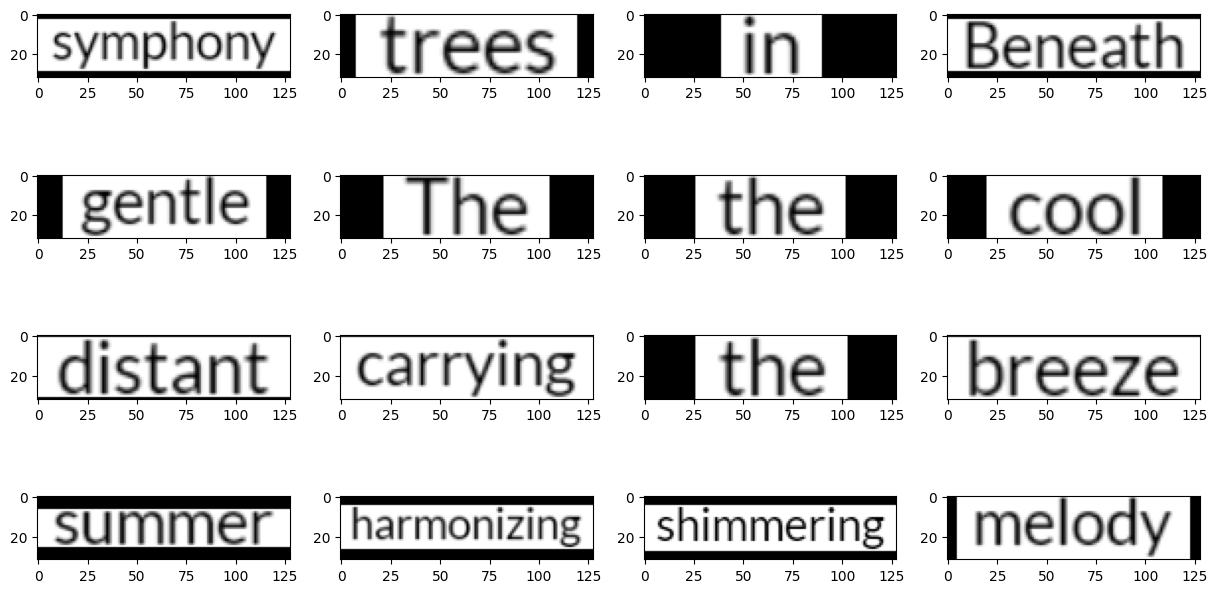

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
  images = data["image"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]
    ax[i // 4, i % 4].imshow(img, cmap="gray")


  plt.show()

In [ ]:
vocab=['k', "'", 'U', '6', 'f', 'l', 'G', 'D', 'b', 'y', 'R', 'Y', 'X', '8', 'Q', 'M', 'e', 'P', 'r', 'i', 'N', 'K', 'v', 'E', 'W', ',', 'T', 'm', '2', 'p', ';', 'j', ')', 'I', '-', '(', 'F', 't', '&', '#', 'a', 'n', 'x', '"', 'B', 'g', '5', 'u', '!', 'J', 'H', 's', 'Z', 'o', 'd', '7', 'S', 'V', 'C', 'c', 'A', '0', '3', '9', 'z', ':', 'O', '.', '?', '/', 'w', '*', '+', '1', 'h', 'L', '4', 'q']

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
char_to_num = StringLookup(vocabulary=vocab, mask_token=None)
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

(64, 128, 32, 1)
2/2 [==============================] - 1s 86ms/step


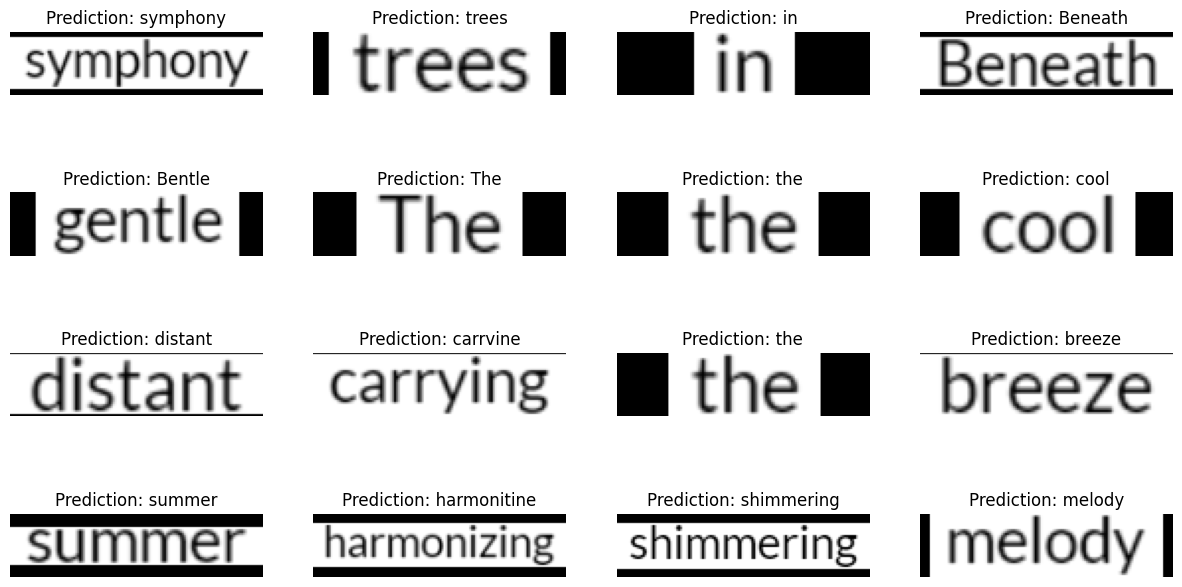

(64, 128, 32, 1)
2/2 [==============================] - 1s 249ms/step


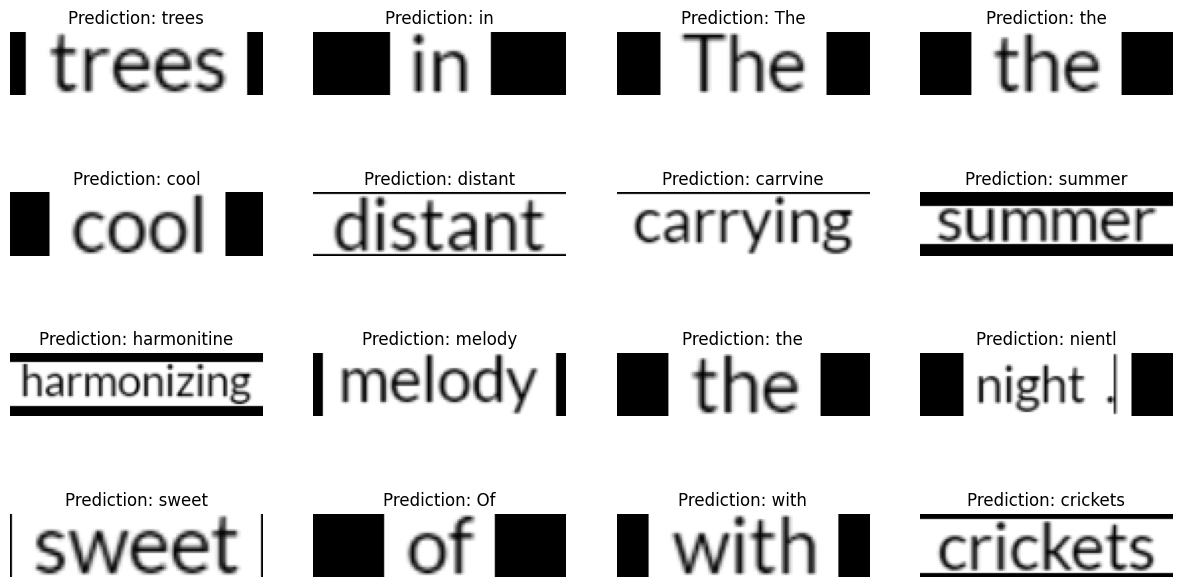

In [ ]:
# Inference on New set of images
pred_test_text = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :21
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in inf_images.take(3):
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    # print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [ ]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['symphony', 'trees', 'in', 'Beneath', 'Bentle', 'The', 'the', 'cool', 'distant', 'carrvine', 'the', 'breeze', 'summer', 'harmonitine', 'shimmering', 'melody', 'the', 'whispered', 'nientl', 'sweet', 'Of', 'with', 'moonlit', 'crickets', 'throush', 'Frasrance', 'the', 'str', 'created', 'thythm', 'the', 'Of', 'symphony', 'trees', 'in', 'Bentle', 'The', 'the', 'cool', 'distant', 'carrvine', 'breeze', 'summer', 'harmonitine', 'melody', 'the', 'whispered', 'nientl', 'sweet', 'Of', 'with', 'crickets', 'throush', 'Frasrance', 'the', 'created', 'Thothmic', 'the', 'Of', 'ancient', 'blooming', 'dance', 'seren', 'symphony', 'trees', 'in', 'The', 'the', 'cool', 'distant', 'carrvine', 'summer', 'harmonitine', 'melody', 'the', 'nientl', 'sweet', 'Of', 'with', 'crickets', 'Frasrance', 'the', 'created', 'Thothmic', 'Of', 'blooming', 'dance', 'serene', 'MONErS', 'Of', 'treflies', 'symphony', 'in', 'The', 'the', 'cool', 'distant', 'summer', 'harmonitine', 'melody', 'nientl', 'Of', 'with', 'crickets', 'th

In [ ]:
sentence = ' '.join(flat_list)
print(sentence)

symphony trees in Beneath Bentle The the cool distant carrvine the breeze summer harmonitine shimmering melody the whispered nientl sweet Of with moonlit crickets throush Frasrance the str created thythm the Of symphony trees in Bentle The the cool distant carrvine breeze summer harmonitine melody the whispered nientl sweet Of with crickets throush Frasrance the created Thothmic the Of ancient blooming dance seren symphony trees in The the cool distant carrvine summer harmonitine melody the nientl sweet Of with crickets Frasrance the created Thothmic Of blooming dance serene MONErS Of treflies symphony in The the cool distant summer harmonitine melody nientl Of with crickets the created Thothmic dance serene Of symphony in the cool summer harmonitine nientl with the Thothmic dance Of Freflies in the cool summer nientl
